In [3]:
import numpy as np
import re
from collections import Counter
import os
import json
import csv
import pickle
import matplotlib.pyplot as plt
import random

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import *
from keras.utils import to_categorical

# fix random seed for reproducibility
np.random.seed(0)

DATA_PATH = 'data/model'
MODEL_PATH = 'model.keras'
START_TOKEN = '<s>'
STOP_TOKEN = '</s>'
NONE_LABEL = 'None'
MAX_SEQUENCE_LENGTH = 1000
EMBEDDINGS_PATH = '/home/philip/freezer/word_embeddings/fb_fasttext_crawl-300d-2M.vec'
EMBEDDINGS_DIM = 300

def ensure_exists(path):
    directory = os.path.dirname(path)
    if not os.path.exists(directory):
        os.makedirs(directory)


Using TensorFlow backend.


In [ ]:
        
def prepare_data(
        multi_label_data_path, 
        none_label_data_path,
        re_labels_path, 
        output_path, 
        embeddings_path, 
        embeddings_dim,
        none_label,
        multi_label_comments_limit,
        none_label_comments_limit,
        max_sequence_length,
        remove_id_token_prob
    ):
    label_regexes = []
    with open(re_labels_path, 'r') as f:
        reader = csv.reader(f)
        next(reader)
        for row in reader:
            ngram, _, label, group = row
            regex_string = '\\s+'.join(ngram.strip().split(' '))
            regex = re.compile(regex_string, re.IGNORECASE)
            label_regexes.append((group, regex))
    
    all_labels = list(set([l[0] for l in label_regexes]))
    all_labels.append(none_label)
    labels_path = os.path.join(output_path, 'labels.txt')
    ensure_exists(labels_path)
    with open(labels_path, 'w') as f:
        for l in all_labels:
            f.write(f'{l}\n')
    
    labeled_comments_path = os.path.join(output_path, 'labeled_comments.dat')
    ensure_exists(labeled_comments_path)
    c = Counter()
    lengths = Counter()
    
    comments = []
    labels = []
    label_index = {l:all_labels.index(l) for l in all_labels}

    with open(multi_label_data_path, 'r') as i:
        for ct, line in enumerate(i):
            if (ct % 10000) == 0:
                print(f'[Multilabel] Processing comment {ct:,}...')

            if ct == multi_label_comments_limit:
                break
                
            data = json.loads(line)
            comment = START_TOKEN + data['body'] + STOP_TOKEN
            label, modified_comment = find_label(comment, label_regexes, remove_id_token_prob)                

            if label is None:
                label = none_label

            comments.append(modified_comment)
            labels.append(label_index[label])
        
        print(f'[Multilabel] Finished reading and labeling {len(labels)} datapoints')
        
    
    with open(none_label_data_path, 'r') as i:
        for ct, line in enumerate(i):
            if (ct % 10000) == 0:
                print(f'[None Label] Processing comment {ct:,}...')

            if ct == none_label_comments_limit:
                break

            data = json.loads(line)
            comment = START_TOKEN + data['body'] + STOP_TOKEN
            label = none_label

            comments.append(comment)
            labels.append(label_index[label])
        
        print(f'[Multilabel] Finished reading and labeling {len(labels)} datapoints')
        
    
    print('Tokenizing and tranforming comments...')
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(comments)
    sequences = tokenizer.texts_to_sequences(comments)
    word_index = tokenizer.word_index
    
    print('Padding comment sequences...')
    data = pad_sequences(sequences, maxlen=max_sequence_length)
    
    print('Transforming labels into one-hot...')
    onehot_labels = to_categorical(np.asarray(labels))
    
    print('Looking up embeddings...')
    embeddings_lookup = {}
    with open(embeddings_path, 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            if word not in word_index:
                continue
            coeffs = np.asarray(values[1:], dtype='float32')
            embeddings_lookup[word] = coeffs

    embedding_matrix = np.zeros((len(word_index) + 1, embeddings_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_lookup.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    print('Writing data...')
    out_data = ((embedding_matrix, 'embeddings'), 
                (onehot_labels, 'labels'), 
                (data, 'comments'),
                (tokenizer, 'tokenizer'))
    for d, name in out_data:
        out_path = os.path.join(output_path, f'{name}.dat')
        ensure_exists(out_path)
        print(f'\tWriting {name} to "{out_path}"')
        with open(out_path, 'wb') as f:
            pickle.dump(d, f, pickle.HIGHEST_PROTOCOL)
    
    print('Done writing data...')

def find_label(comment, label_regexes, remove_prob):
    remove = random.random() > remove_prob
    
    c = Counter()
    modified_comment = comment
    for label, regex in label_regexes:
        if regex.search(comment):
            c[label] += 1
            
            if remove:
                modified_comment = re.sub(regex, "", modified_comment)

    labels = c.most_common(1)
    if len(labels) == 0:
        return None, modified_comment
    else:
        return labels[0][0], modified_comment

prepare = False
num_comments = int(5e5)
none_comments_mult = 1

if prepare is True:
    prepare_data(
        multi_label_data_path = 'data/hate_comments.json', 
        none_label_data_path = 'data/none_comments.json',
        re_labels_path = 'data/refined_ngram_dict_labeled.csv', 
        embeddings_path = EMBEDDINGS_PATH,
        embeddings_dim = EMBEDDINGS_DIM,
        output_path = DATA_PATH, 
        max_sequence_length=MAX_SEQUENCE_LENGTH, 
        multi_label_comments_limit = num_comments,
        none_label_comments_limit = none_comments_mult * num_comments,
        none_label=NONE_LABEL,
        remove_id_token_prob=0.5
    )

In [4]:
def read_data(output_path):
    embeddings_path = os.path.join(output_path, 'embeddings.dat')
    embeddings_matrix = pickle.load(open(embeddings_path, 'rb'))
    
    labels_path = os.path.join(output_path, 'labels.dat')
    labels = pickle.load(open(labels_path, 'rb'))
    
    comments_path = os.path.join(output_path, 'comments.dat')
    comments = pickle.load(open(comments_path, 'rb'))
    
    return comments, labels, embeddings_matrix

comments, labels, embeddings_matrix = read_data(DATA_PATH)
print(comments.shape, labels.shape, embeddings_matrix.shape)

(1000000, 1000) (1000000, 4) (687912, 300)


In [5]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers.embeddings import Embedding

def create_model(
        embedding_matrix,
        sequence_length,
        output_dim,
        optimizer
    ):
    
    model = Sequential()
    vocab_size, embedding_dim = embedding_matrix.shape
    recurrent_dimension = embedding_dim
    dropout = 0.5
    
    
    print('Creating model...')
    model.add(Embedding(vocab_size, 
                        embedding_dim, 
                        weights=[embedding_matrix], 
                        input_length=sequence_length, 
                        trainable=False))

    model.add(LSTM(recurrent_dimension, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(recurrent_dimension))
    model.add(Dropout(dropout))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(output_dim, activation='softmax'))
    
    print('Compiling model...')
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    print('Finished creating model!')
    return model

In [ ]:
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, CSVLogger
from livelossplot import PlotLossesKeras

model = create_model(embeddings_matrix, MAX_SEQUENCE_LENGTH, labels.shape[-1], 'adam')
model.summary()

X_train, X_test, y_train, y_test = train_test_split(comments, labels, test_size=0.10)
checkpoint_path = os.path.join(DATA_PATH, MODEL_PATH)
ensure_exists(checkpoint_path)
checkpoint = ModelCheckpoint(checkpoint_path, verbose=1, save_best_only=True)
logger = CSVLogger('training.log')
train = model.fit(X_train, y_train, batch_size=256, epochs=10, validation_split=0.22, verbose=1, callbacks=[checkpoint, PlotLossesKeras(), logger])
model.load_weights(os.path.join(DATA_PATH, MODEL_PATH))
model.evaluate(X_test, y_test, verbose=1)

In [6]:
model = create_model(embeddings_matrix, MAX_SEQUENCE_LENGTH, labels.shape[-1], 'adam')
model.load_weights(os.path.join(DATA_PATH, MODEL_PATH))

Creating model...
Compiling model...
Finished creating model!


In [7]:
class Predictor:
    def __init__(self, data_path, model_path, max_sequence_length):
        self.max_sequence_length = max_sequence_length
        
        def load_pickle(name):
            with open(os.path.join(data_path, name + '.dat'), 'rb') as f:
                return pickle.load(f)
            
        embeddings_matrix = load_pickle('embeddings')
        self.tokenizer = load_pickle('tokenizer')
        
        self.labels = []
        with open(os.path.join(data_path, 'labels.txt'), 'r') as f:
            for l in f:
                l = l.strip()
                if len(l):
                    self.labels.append(l)
        
        self.model = create_model(embeddings_matrix, max_sequence_length, len(self.labels), 'rmsprop')
        self.model.load_weights(os.path.join(data_path, model_path))

    def predict(self, comments):
        padded_comments = [START_TOKEN + c + STOP_TOKEN for c in comments]
        sequences = self.tokenizer.texts_to_sequences(padded_comments)
        X = pad_sequences(sequences, maxlen=self.max_sequence_length)
        predictions = self.model.predict(X)
        labels, confidences =zip(*[(self.labels[x], predictions[i][x]) for i, x in enumerate(np.argmax(predictions, axis=1))])
        return comments, labels, confidences

p = Predictor(DATA_PATH, MODEL_PATH, MAX_SEQUENCE_LENGTH)

Creating model...
Compiling model...
Finished creating model!


In [ ]:
from time import time as get_time
from itertools import islice, chain
import datetime
import math

def batch(iterable, size):
    sourceiter = iter(iterable)
    while True:
        batchiter = islice(sourceiter, size)
        yield chain([next(batchiter)], batchiter)

def count_lines(path):
    with open(path, 'r') as f:
        for i, _ in enumerate(f):
            continue
        
        return i
def label_comments(path, batch_size):
    num_lines = count_lines(unlabeled_comments_path)
    num_batches = math.ceil(num_lines/batch_size)

    in_path = path
    out_path = f'labeled_{path}'
    log_path = f'{path}.log'
        
    batch_times = []
    def get_time_remaining(batch_index):
        if len(batch_times) < 1:
            return "N/A"
        
        avg_time = np.mean(batch_times[-5:])
        remaining_batches = num_batches - 1 - batch_index
        remaining_time = avg_time * remaining_batches
        return str(datetime.timedelta(seconds=int(remaining_time)))
    
    with open(in_path, 'r') as in_f, open(out_path, 'w') as out_f, open(log_path, 'w') as log_f:
        for b_index, b in enumerate(batch(in_f, batch_size)):
            gtr = get_time_remaining(b_index)
            log = f'Processing batch {b_index:,} of {num_batches:,} | {gtr} remaining...'
            print(log, end='\r')
            log_f.write(log)
            log_f.flush()
            
            start_time = get_time()
            data = [json.loads(s) for s in b]
            comments = [d['body'] for d in data]
            _,labels, _ = p.predict(comments)
            for d, l in zip(data, labels):
                d['label'] = l
                d['re_label'] = NONE_LABEL
                json.dump(d, out_f)
                out_f.write('\n')
            duration = get_time() - start_time
            batch_times.append(duration)

unlabeled_comments_path = ''
batch_size = 1024
label_comments(unlabeled_comments_path, batch_size)            

In [24]:
topics = [['people', 'think', 'know', 'make', 'shit', 'want', 'good', 'thing', 'ha', 'time', 'gt', 'doe', 'work', 've', 'come'],
  ['fuck', 'lover', 'shit', 'stupid', 'bitch', 'fat', 'idiot', 'cunt', 'retard', 'man', 'god', 'shut', 'piece', 'holy', 'dumb'],
  ['faggot', 'lol', 'post', 'ban', 'sjw', 'gaf', 'gay', 'thread', 'beta', 'mod', 'love', 'sub', 'game', 'guy', 'little'],
  ['wa', 'year', 'time', 'school', 'kid', 'tell', 'guy', 'saw', 'day', 'think', 'ago', 'friend', 'cop', 'shoot', 'old'],
  ['like', 'look', 'act', 'sound', 'shit', 'guy', 'treat', 'girl', 'human', 'talk', 'feel', 'dog', 'animal', 'woman', 'smell'],
  ['hate', 'fat', 'people', 'sub', 'god', 'bitch', 'jew', 'coontown', 'cunt', 'really', 'hat', 'racist', 'reason', 'gay', 'crime'],
  ['white', 'trash', 'people', 'woman', 'man', 'race', 'asian', 'jew', 'men', 'kill', 'negro', 'girl', 'country', 'privilege', 'hispanic'],
  ['black', 'people', 'crime', 'race', 'behavior', 'racist', 'culture', 'person', 'difference', 'gt', 'commit', 'american', 'negro', 'mean', 'population'],
  ['just', 'want', 'mean', 'bad', 'll', 'wait', 'stupid', 'think', 'dumb', 'point', 'really', 'maybe', 'doe', 'typical', 'happen'],
  ['say', 'word', 'racist', 'mean', 'll', 'talk', 'thing', 'hear', 'guy', 'point', 'lover', 'lol', 'comment', 'ask', 've']]

all_words = set()
for t in topics:
    all_words.update(t)
print(len(all_words))

109


In [25]:
embeddings_lookup = {}
with open(EMBEDDINGS_PATH, 'r') as f:
    for i, line in enumerate(f):
        if i % 10000 == 0:
            print(f'{i:,}', end='\r')
        
        values = line.split()
        word = values[0]
        if word not in all_words:
            continue
        coeffs = np.asarray(values[1:], dtype='float32')
        embeddings_lookup[word] = coeffs

2


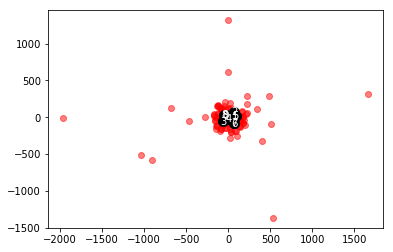

3


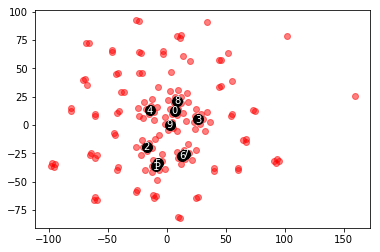

4


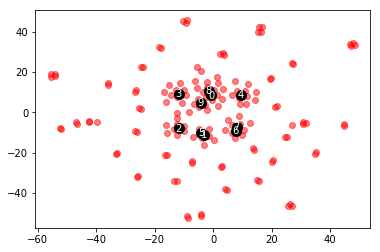

5


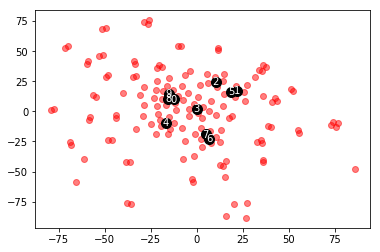

6


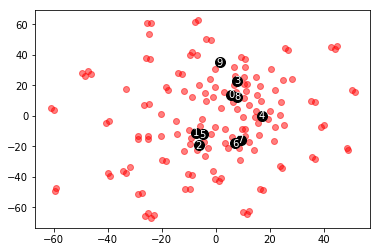

7


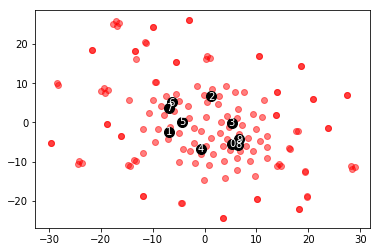

8


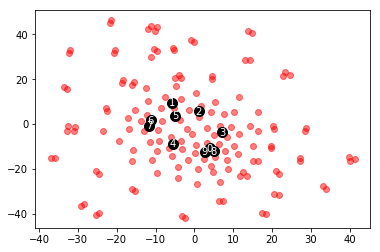

9


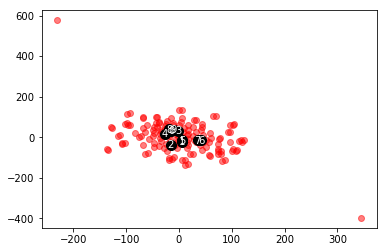

In [92]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import Axes3D

topic_sums = []
word_embs = []
for t in topics:
    embs = [embeddings_lookup[w] for w in t if w in embeddings_lookup]
    word_embs.extend(embs)
    emb_sum = np.mean(np.asarray(embs), axis=0)
    topic_sums.append(emb_sum)

for ppl in range(2, 10):
    print(ppl)
    tsne = TSNE(n_components=2, perplexity=ppl)
    # topic_points = tsne.fit_transform(topic_sums)
    # word_points = tsne.fit(np.asarray(word_embs))
    comb_points = tsne.fit_transform(topic_sums + word_embs)

    x_word,y_word = zip(*comb_points[len(topics):])
    x_topic, y_topic = zip(*comb_points[:len(topics)])

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(x_word, y_word, alpha=0.5, color='red')
    ax.scatter(x_topic, y_topic, 100, alpha=1.00, color='black')
    for i, (x,y) in enumerate(zip(x_topic, y_topic)):
#         x,y = int(x), int(y)
        ax.text(x,y, i, ha="center", va="center", color='white')

    plt.show()


In [101]:
from gensim.models import FastText, KeyedVectors
gmodel = KeyedVectors.load_word2vec_format(EMBEDDINGS_PATH)

In [123]:
from pprint import pprint
topic_groups = ([4], [9,8,0], [2], [5,1], [7,6], [3])
most_similar = []
for tg in topic_groups:
    l = f'\\item Group {tg}: '
#     print(f'Group: {tg}')
    g_ms = []
    g_ms.append([w[0] for w in gmodel.similar_by_vector(np.mean([topic_sums[t] for t in tg], axis=0))[:5]])
    l += ', '.join(g_ms[-1])
    print(l)
#     pprint(g_ms[-1])
#     for t in tg:
#         t_vec = topic_sums[t]
#         g_ms.append(gmodel.similar_by_vector(t_vec))
#         pprint(g_ms[-1])
    most_similar.append((tg, g_ms))

\item Group [4]: girl, man, dog, woman, smell
\item Group [9, 8, 0]: think, say, do, really, just
\item Group [2]: faggit, faggot, r9k, phaggot, mod
\item Group [5, 1]: bitch, asshole, fucker, dickhead, fucking
\item Group [7, 6]: negro, nigger, hispanic, racist, white
\item Group [3]: guy, kid, friend, day, year


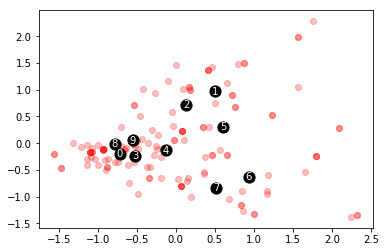

In [95]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

topic_sums = []
word_embs = []
for t in topics:
    embs = [embeddings_lookup[w] for w in t if w in embeddings_lookup]
    word_embs.extend(embs)
    emb_sum = np.mean(np.asarray(embs), axis=0)
    topic_sums.append(emb_sum)

pca = PCA(n_components=2)
topic_points = pca.fit_transform(topic_sums)
word_points = pca.transform(np.asarray(word_embs))

x_word,y_word = zip(*word_points)
x_topic, y_topic = zip(*topic_points)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x_word, y_word, alpha=0.25, color='red')
ax.scatter(x_topic, y_topic, 125, alpha=1.00, color='black')
for i, (x,y) in enumerate(zip(x_topic, y_topic)):
    ax.text(x,y, i, ha="center", va="center", color='white')

plt.show()


0
1
2
3
4
5
6
7
8
9


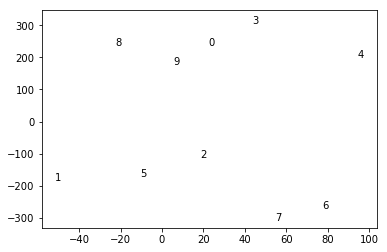

In [43]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from pylab import rcParams

import matplotlib.mlab as mlab

topic_sums = []
for t in topics:
    embs = np.asarray([embeddings_lookup[w] for w in t if w in embeddings_lookup])
    emb_sum = np.sum(embs, axis=0)
    topic_sums.append(emb_sum)
tsne = TSNE(n_components=2, perplexity=2).fit_transform(topic_sums)
plt.figure()
for i, ((x,y),) in enumerate(zip(tsne)):
    x,y = int(x), int(y)
    print(i)
    plt.text(x,y,i, ha="center", va="center")
    
plt.scatter(tsne[:,0], tsne[:, 1], alpha=0)
plt.show()



In [114]:
import csv
train_data = []
with open('training.log', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    for d in reader:
        train_data.append(d)
    
epoch, acc, loss, val_acc, val_loss = zip(*train_data)

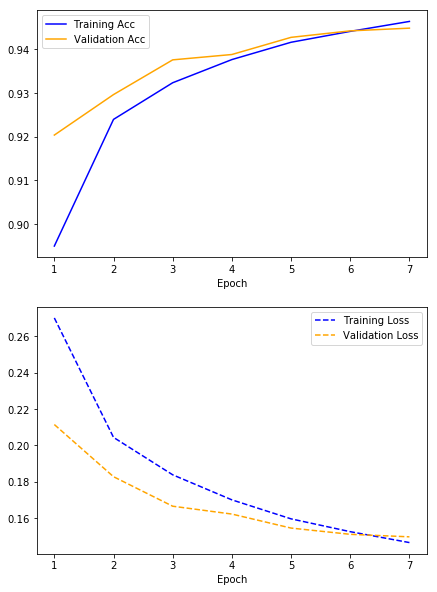

In [115]:
rcParams['figure.figsize'] = 7, 10
plt.subplot(2,1,1)
index = range(1, 1+ len(epoch))
plt.plot(index, acc, label='Training Acc', color='blue')
plt.plot(index, val_acc, label='Validation Acc', color='orange')
plt.legend()
plt.xlabel('Epoch')
plt.subplot(2,1,2)
plt.plot(index, loss, '--', label='Training Loss', color='blue')
plt.plot(index, val_loss, '--', label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.legend()
plt.show()